# Temporal Graph Neural Networks

In [2]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-geometric-temporal==0.54.0

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 78.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.

## Forecasting web traffic

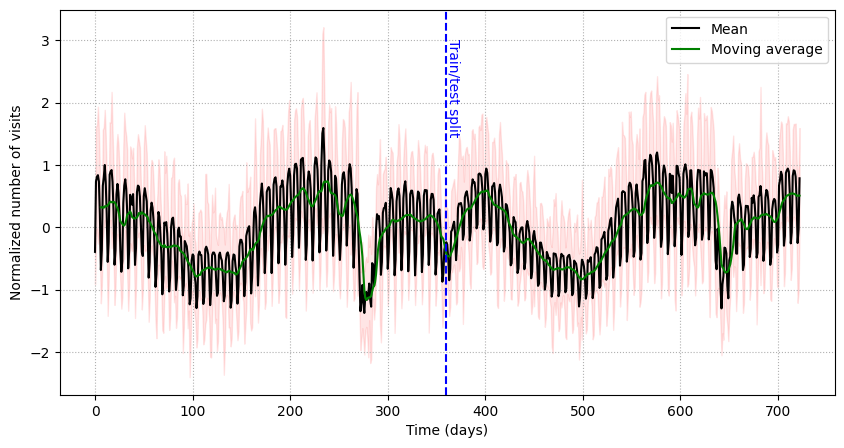

In [3]:
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = WikiMathsDatasetLoader().get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5) # 전체 기간의 앞의 반은 트레이닝, 뒤의 반은 테스트

mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
df['rolling'] = df['mean'].rolling(7).mean() # 7일 평균 값

plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

In [4]:
import torch
torch.manual_seed(0)

# EvolveGCN-H 버전
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.linear = torch.nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

# TemporalGNN 모델을 초기화
model = TemporalGNN(dataset[0].x.shape[0], dataset[0].x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

# Training
for epoch in tqdm(range(50)):
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_pred-snapshot.y)**2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE = {loss.item():.4f}')

100%|██████████| 50/50 [05:24<00:00,  6.48s/it]


MSE = 0.7893


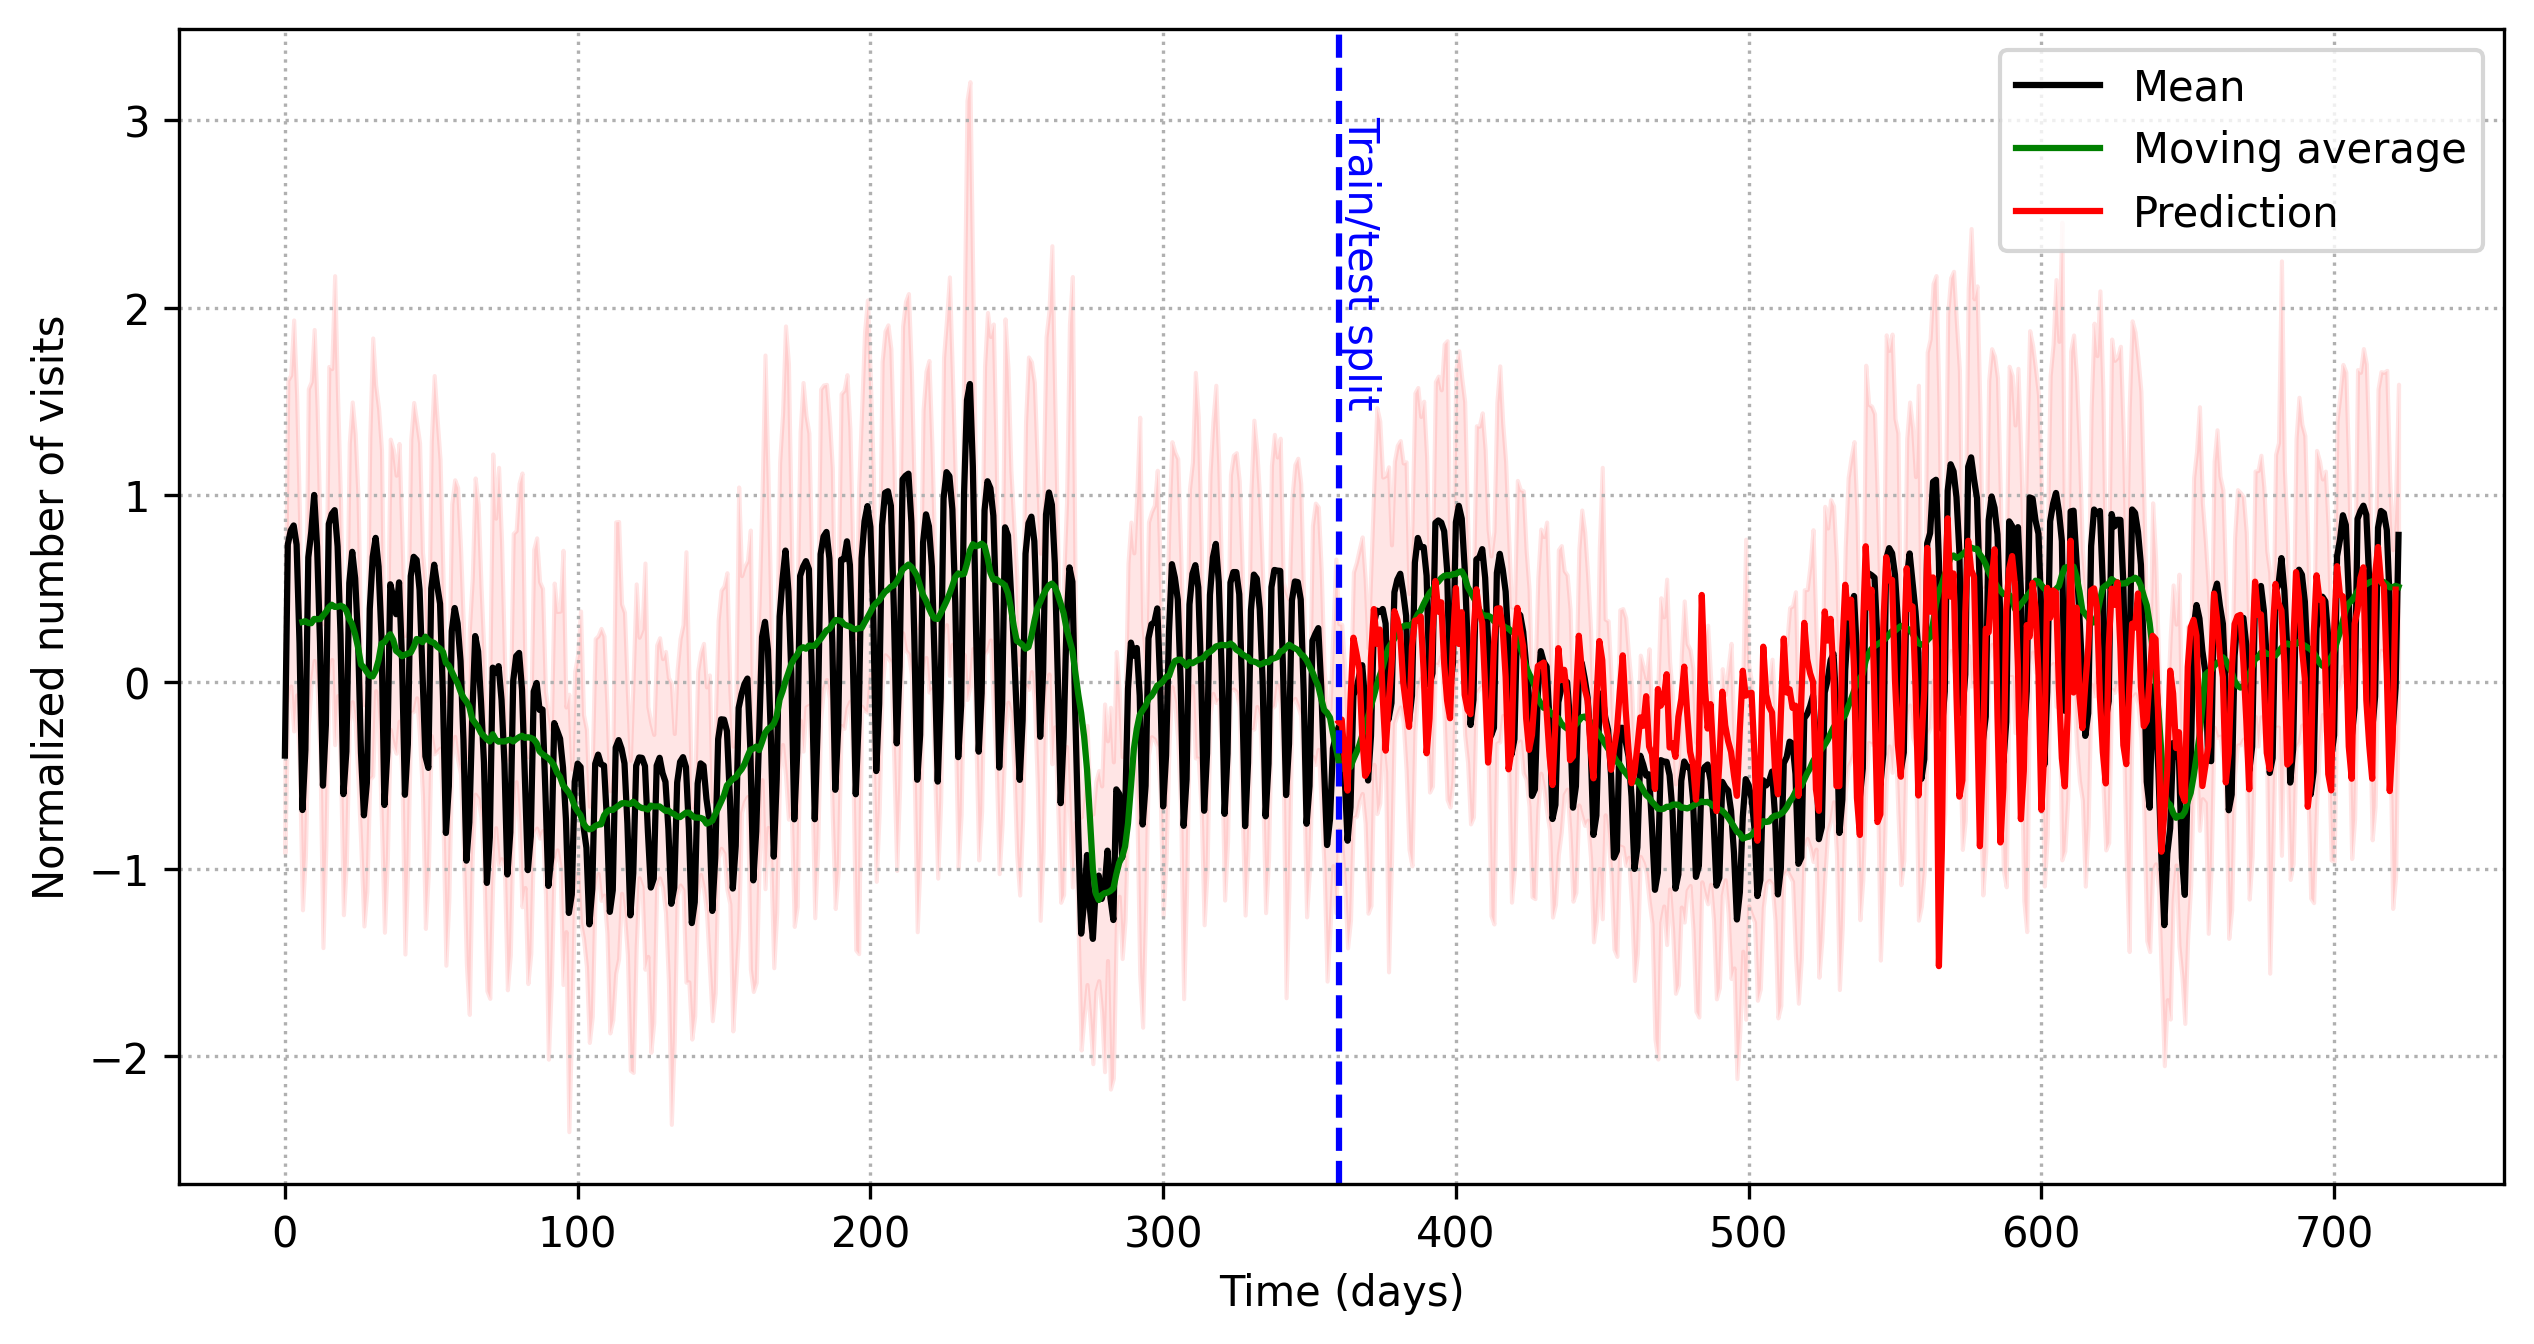

In [5]:
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.plot(range(360,722), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

<Axes: >

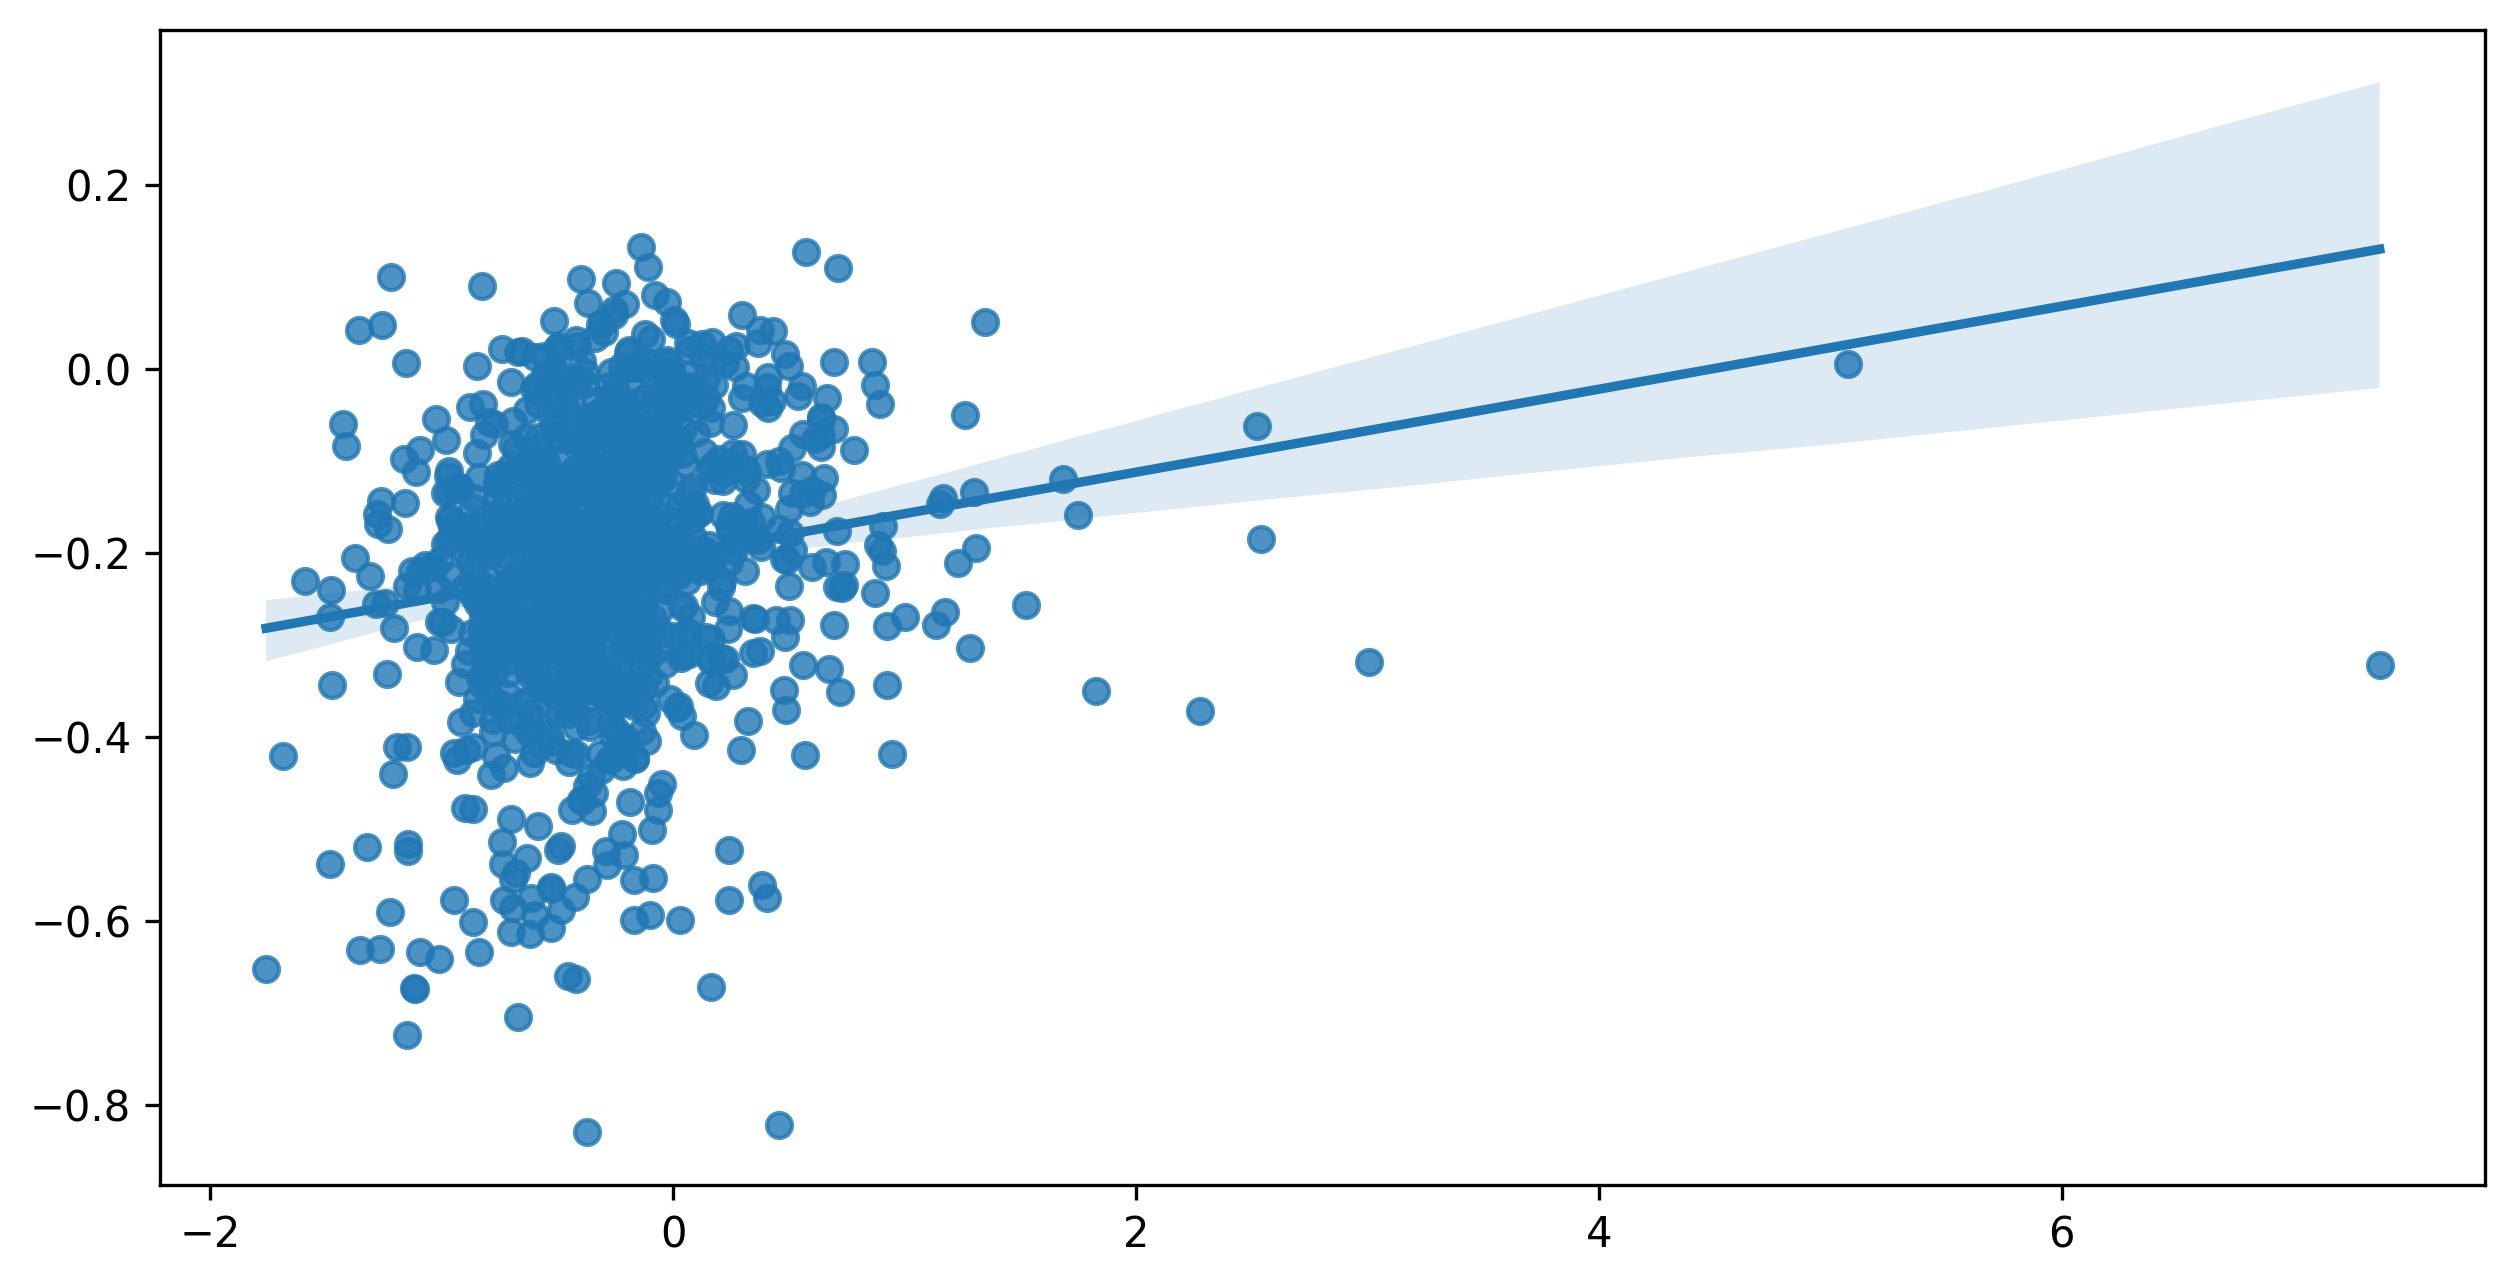

In [6]:
import seaborn as sns

# 제값과 예측값 사이의 관계를 선형 회귀 그래프
y_pred = model(test_dataset[0].x, test_dataset[0].edge_index, test_dataset[0].edge_attr).detach().squeeze().numpy()

plt.figure(figsize=(10,5), dpi=300)
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred)

In [7]:
from torch_geometric_temporal.nn.recurrent import EvolveGCNO
# EvolveGCN-O 버전
class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNO(dim_in, 1)
        self.linear = torch.nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(dataset[0].x.shape[1])

## Predicting cases of COVID-19

Text(0, 0.5, 'Mean normalized number of cases')

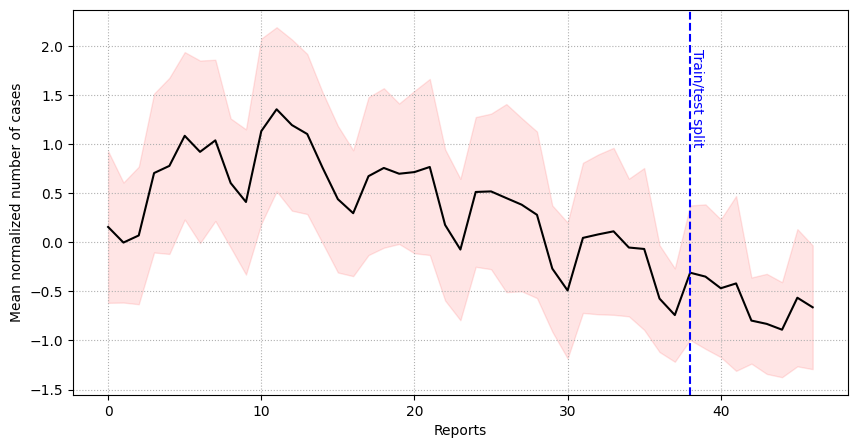

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

dataset = EnglandCovidDatasetLoader().get_dataset(lags=14) #  14일 간격으로 데이터를 나누어 사용
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])

plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Reports')
plt.ylabel('Mean normalized number of cases')

In [9]:
from torch_geometric_temporal.nn.recurrent import MPNNLSTM

class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, num_nodes):
        super().__init__()
        self.recurrent = MPNNLSTM(dim_in, dim_h, num_nodes, 1, 0.5)
        self.dropout = torch.nn.Dropout(0.5)
        self.linear = torch.nn.Linear(2*dim_h + dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.dropout(h)
        h = self.linear(h).tanh()
        return h

model = TemporalGNN(dataset[0].x.shape[1], 64, dataset[0].x.shape[0])
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

# Training
for epoch in tqdm(range(100)):
    loss = 0
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = loss + torch.mean((y_pred-snapshot.y)**2)
    loss = loss / (i+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE: {loss.item():.4f}')

TemporalGNN(
  (recurrent): MPNNLSTM(
    (_convolution_1): GCNConv(14, 64)
    (_convolution_2): GCNConv(64, 64)
    (_batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_recurrent_1): LSTM(128, 64)
    (_recurrent_2): LSTM(64, 64)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=142, out_features=1, bias=True)
)


100%|██████████| 100/100 [00:28<00:00,  3.55it/s]

MSE: 1.4751


Text(0, 0.5, 'Mean normalized number of cases')

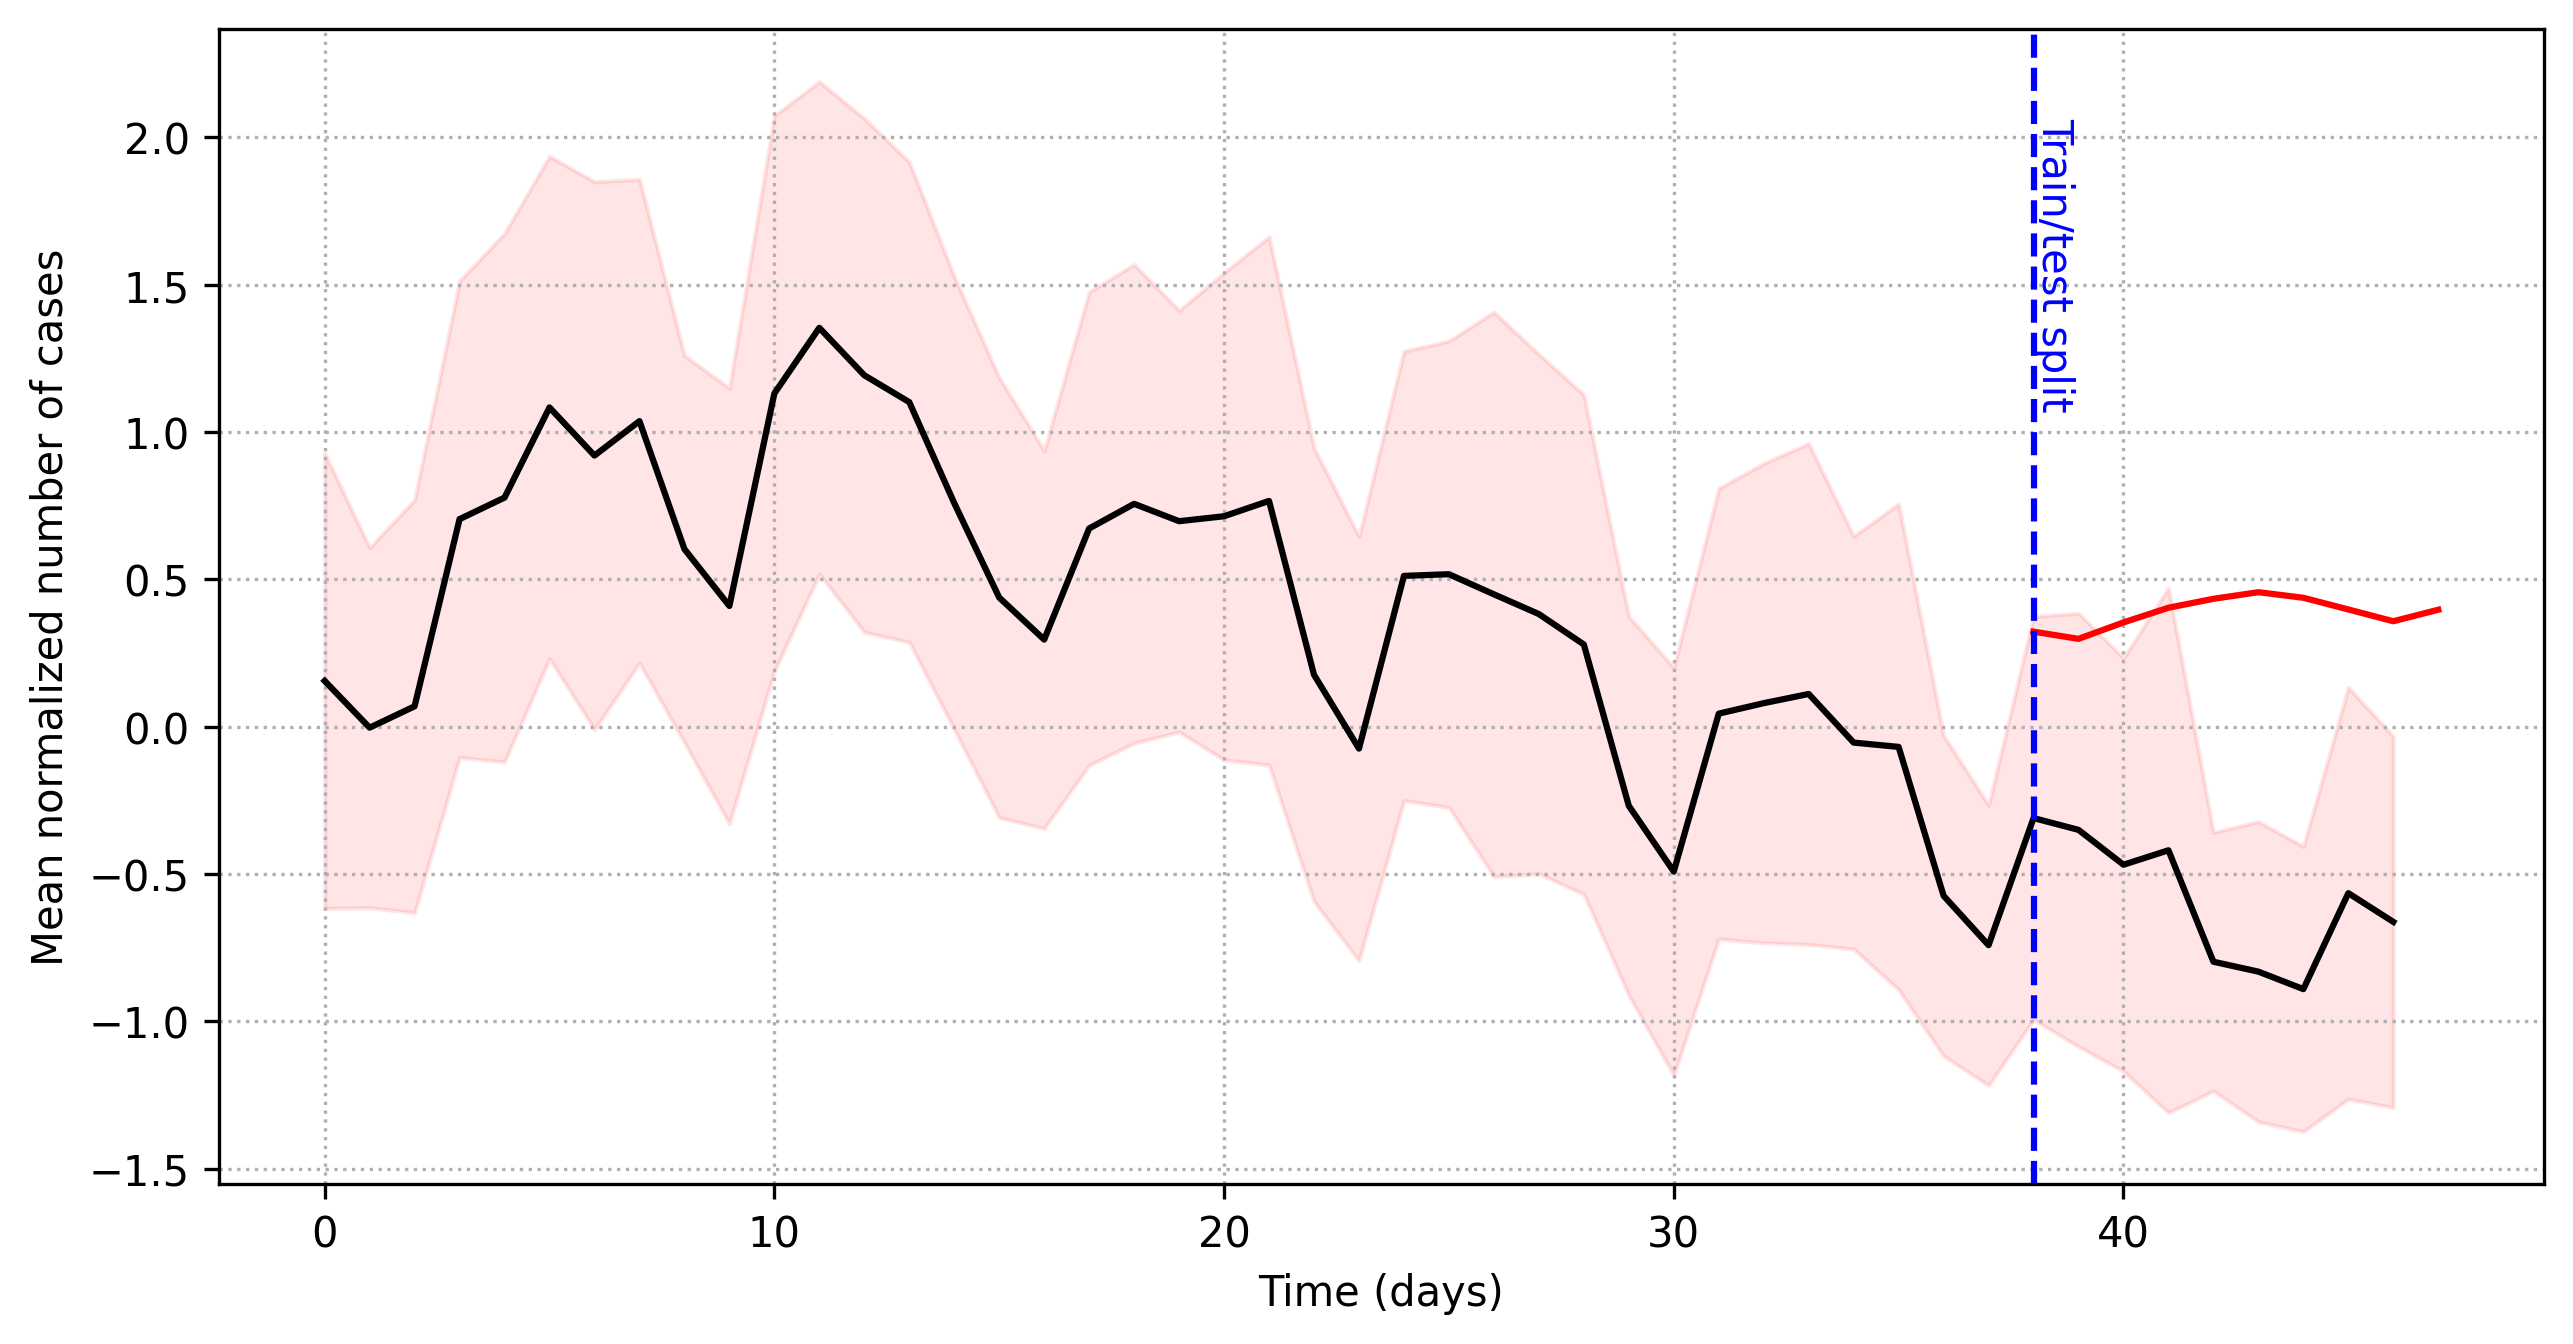

In [10]:
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-')
plt.plot(range(38,48), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1.1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Mean normalized number of cases')

# 아마도 MSE 손실을 최소화하지만 곡선에 맞지 않는 평균값을 학습하고 주기성을 이해했기 때문에 성능이 안좋음

<Axes: >

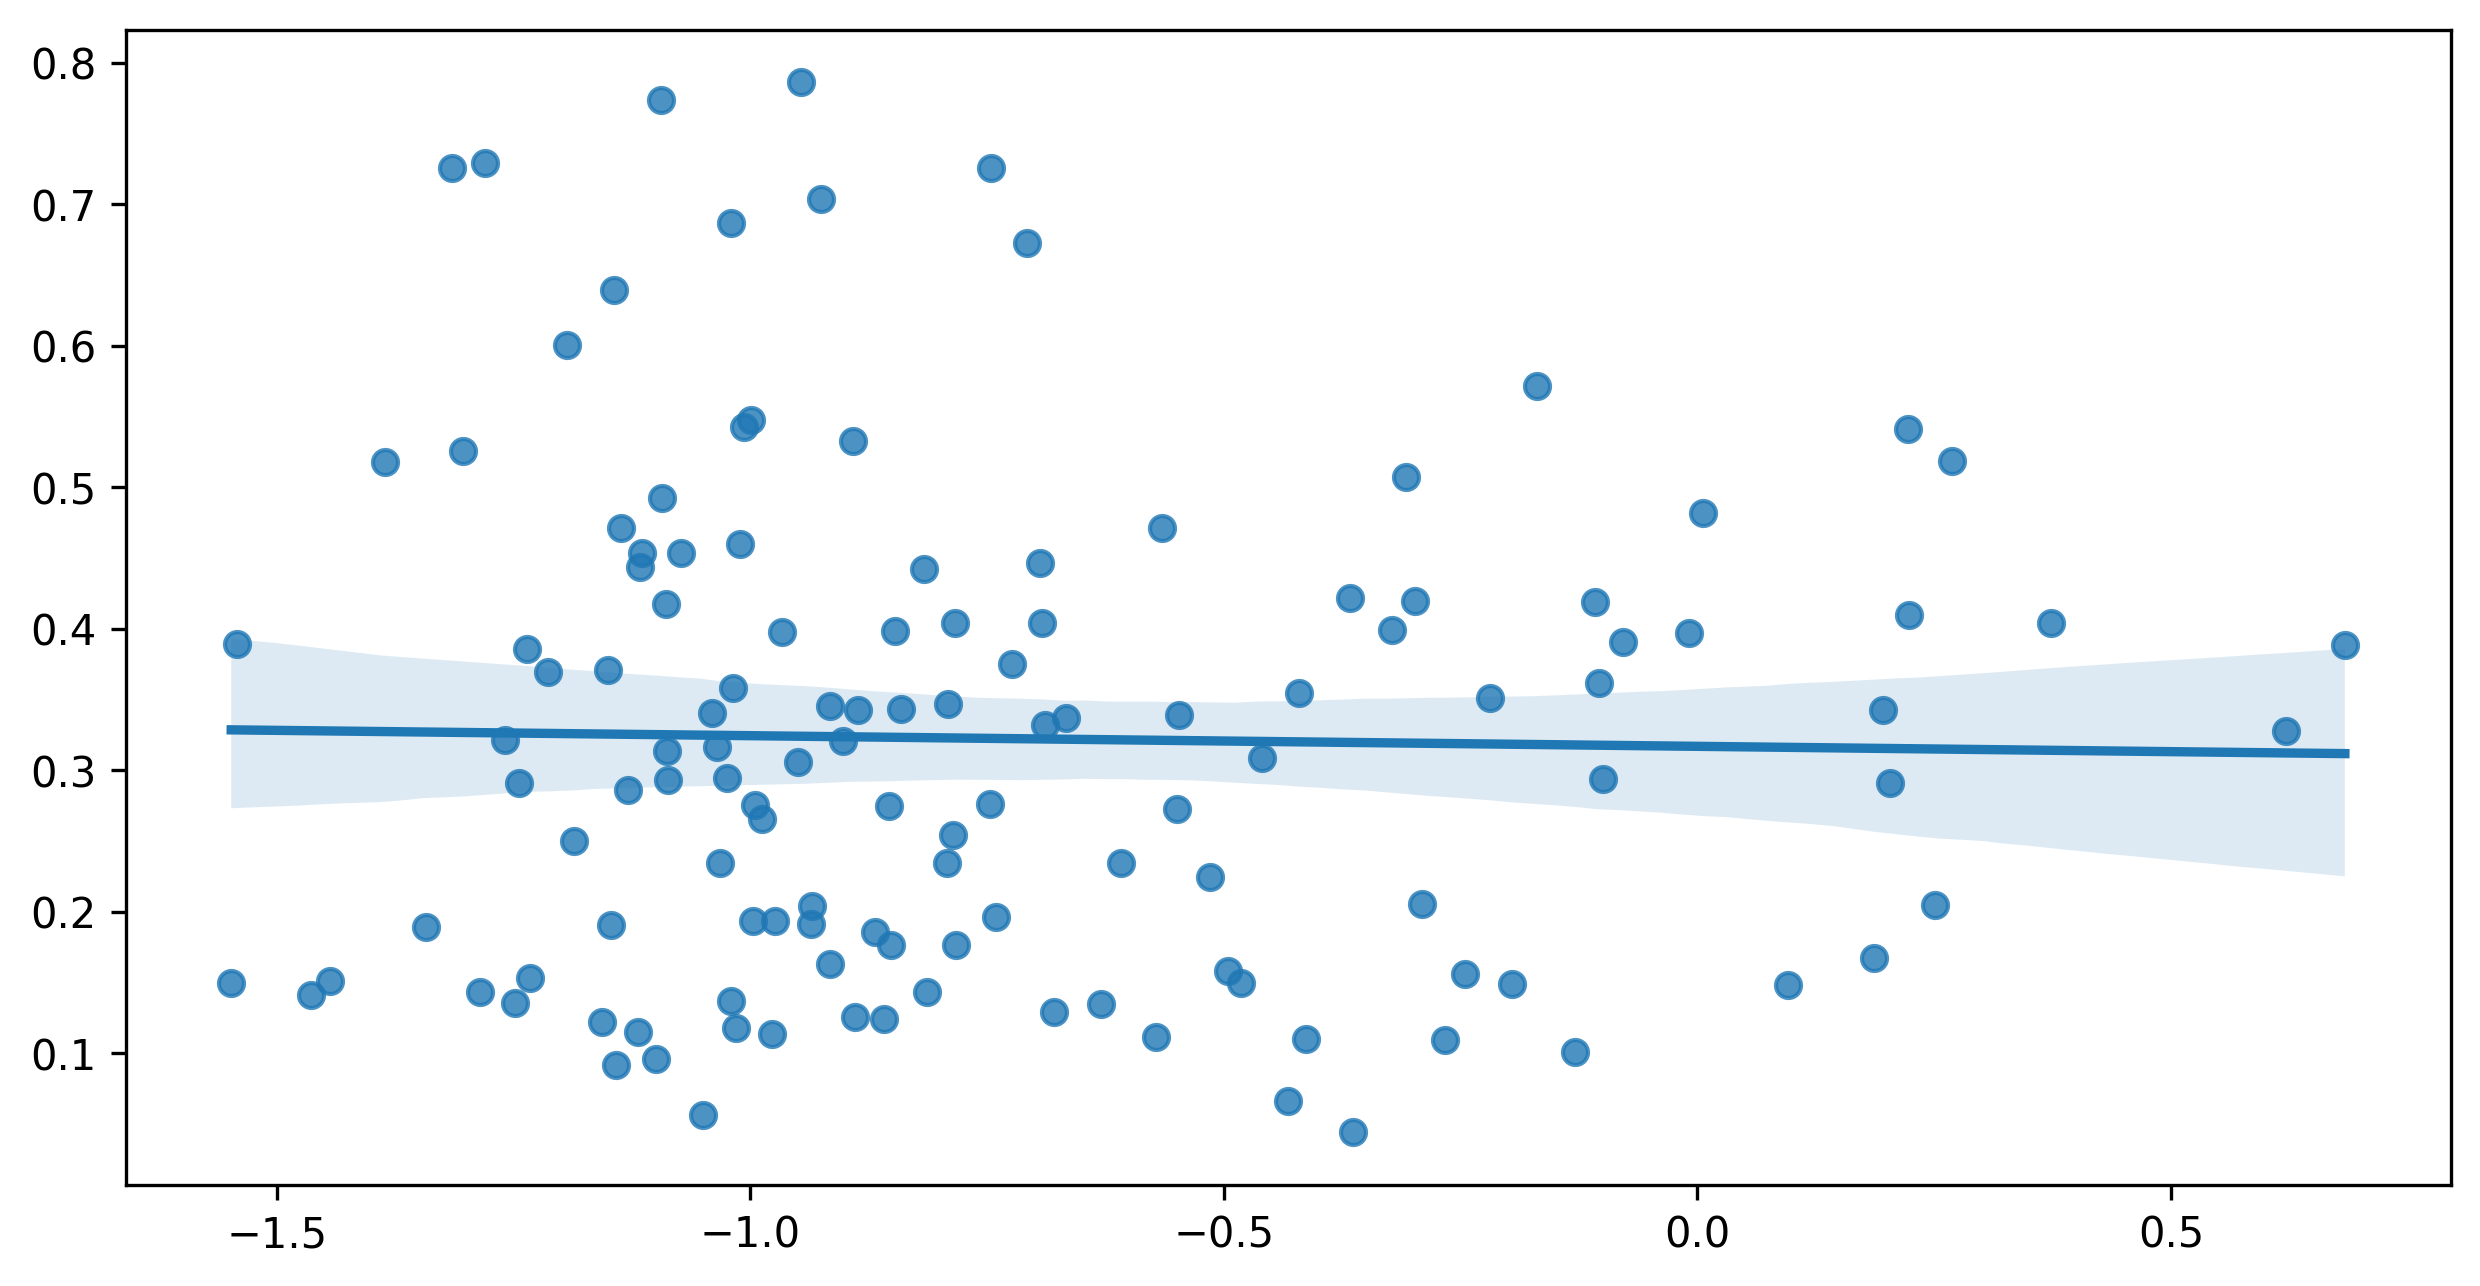

In [11]:
import seaborn as sns

y_pred = model(test_dataset[0].x, test_dataset[0].edge_index, test_dataset[0].edge_attr).detach().squeeze().numpy()

plt.figure(figsize=(10,5), dpi=300)
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred)